Although Python is fairly easy to learn, it poses some difficulties when one is concerned with real world, rather than theoretical performance.  Object methods are implemented in C which makes top-level logic comparitively very slow, and some optimizations have been applied that result in counterintuitive performance results.  This means that some care is required when using Python as a language for teaching.

Here we consider examples of these issues.

# Requirements

In [68]:
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import timeit

# Quicksort

We implement the quicksort function in two ways:
1. purely funcitonal
1. iterative, and in-place

Since the functional approach requires the creation of many lists and deep recursion, intuitively, it should be slower than the in-place iterative approach that has very little overhead.

## Testing

To ensure corrrectness of the implementation we need some utility functions.  A function that returns true if the argument is a sorted list, and one to generate all lists of integers upto (not including) a given length.

In [54]:
def is_sorted(data):
    return all(map(lambda t: t[0] <= t[1], zip(data[:-1], data[1:])))

In [48]:
def generate_test_data(max_values):
    for nr_values in range(max_values):
        for values in itertools.combinations_with_replacement(range(nr_values), nr_values):
            for data in itertools.permutations(values):
                yield list(data)

A third function tests whether two given lists have the same elements.

In [51]:
def have_same_element(data1, data2):
    tmp_data = data1.copy()
    for value in data2:
        tmp_data.remove(value)
    return len(tmp_data) == 0

## Implementations

### Functional implementation

The partition function returns a tuple with
1. the elements of the original list that are smaller than the pivot element,
1. the pivot element
1. the elements of the original list that are larger or equal than the pivot.

In [1]:
def partition_functional(data):
    smaller, larger = list(), list()
    pivot = data[-1]
    for value in data[:-1]:
        if value < pivot:
            smaller.append(value)
        else:
            larger.append(value)
    return smaller, pivot, larger

Quicksort is implemented recursively, it will do two recursive calls on the lists returned by the partition function, and return a new list.

In [2]:
def quicksort_functional(data):
    if len(data) < 2:
        return data
    else:
        smaller, pivot, larger = partition_functional(data)
        return quicksort_functional(smaller) + [pivot] + quicksort_functional(larger)

Test the implementation.

In [55]:
for data in generate_test_data(6):
    sorted_data = quicksort_functional(data)
    if not (is_sorted(sorted_data) and have_same_element(sorted_data, data)):
        print('problem for', data, '->', sorted_data)        

### Iterative and in-place

For this implementation, the partition function moves the elments in the list passed innto it, and returns the index of the pivot element when the partition is done.

In [21]:
def partition_iterative(data, left, right):
    pivot = data[right]
    insert = left - 1
    for i in range(left, right + 1):
        if data[i] < pivot:
            insert += 1
            data[insert], data[i] = data[i], data[insert]
    insert += 1
    data[insert], data[right] = data[right], data[insert]
    return insert

The iterative, in-place implementation of quicksort simulates the recursive function calls by maintaining a stack that holds the left and the right indices of the values that are still to be sorted..  To avoid 

In [41]:
def quicksort_iterative(data):
    if len(data):
        stack = [None]*len(data)
        top = 0
        stack[top] = (0, len(data) - 1)
        while top >= 0:
            left, right = stack[top]
            top -= 1
            pivot_idx = partition_iterative(data, left, right)
            if left < pivot_idx - 1:
                top += 1
                stack[top] = (left, pivot_idx - 1)
            if pivot_idx + 1 < right:
                top += 1
                stack[top] = (pivot_idx + 1, right)

Test the implementation.

In [56]:
for data in generate_test_data(6):
    orig_data = data.copy()
    quicksort_iterative(data)
    if not (is_sorted(data) and have_same_element(orig_data, data)):
        print('problem for', orig_data, '->', data)        

## Performance comparison

To measure performance, we run an algorithm (`algorithm`) a number of times (`nr_runs`) on independently generated data of various sizes (`data_sizes`).  Prior to each individual run of the algorithm, the data is initialized to ensure independence between runs and to get a statistically relevant (?) result (`init_data`).

In [42]:
def time_algorithm(algoritjhm, nr_runs, data_sizes, init_data):
    times = [list(), list()]
    for data_size in data_sizes:
        for _ in range(nr_runs):
            data = init_data(data_size)
            time = timeit.timeit(lambda: algoritjhm(data), number=1)
            times[0].append(data_size)
            times[1].append(time)
    return times

### Lists

In this case, the data is a sequence of floating point values independently sampled from a uniform random distribution of values between 0 and 1.

In [57]:
def init_list(n):
    return  [random.random() for _ in range(n)]

We measure for both implementations and plot the results.

In [44]:
data_sizes, times_func_qsort = time_algorithm(quicksort_functional, 10, [5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000], init_list)

In [45]:
data_sizes, times_iter_qsort = time_algorithm(quicksort_iterative, 10, [5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000], init_list)

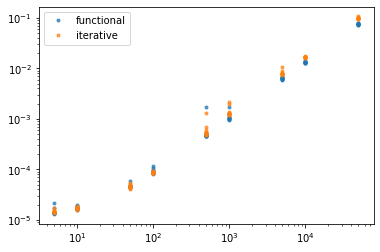

In [46]:
_ = plt.loglog(data_sizes, times_func_qsort, '.', label='functional', alpha=0.7)
_ = plt.loglog(data_sizes, times_iter_qsort, '.', label='iterative', alpha=0.7)
_ = plt.legend()

Somewhat counterintuitively, the functional implementation yields better performance thatn the iterative in-place implementation.  The former has overhead for
* creating many small lists and
* many function calls with corresponding updates of the call stack.

### Arrays

Now the data is a sequence of floating point values independently sampled from a uniform random distribution of values between 0 and 1, but stored in a numpy arrays, rather than a Python list.

In [60]:
def init_array(n):
    return  np.random.uniform(size=n)

We measure for both implementations and plot the results.

In [61]:
data_sizes, times_func_qsort_array = time_algorithm(quicksort_functional, 10, [5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000], init_array)

In [62]:
data_sizes, times_iter_qsort_array = time_algorithm(quicksort_iterative, 10, [5, 10, 50, 100, 500, 1_000, 5_000, 10_000, 50_000], init_array)

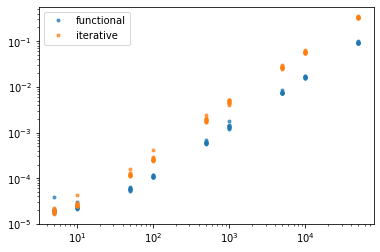

In [63]:
_ = plt.loglog(data_sizes, times_func_qsort_array, '.', label='functional', alpha=0.7)
_ = plt.loglog(data_sizes, times_iter_qsort_array, '.', label='iterative', alpha=0.7)
_ = plt.legend()

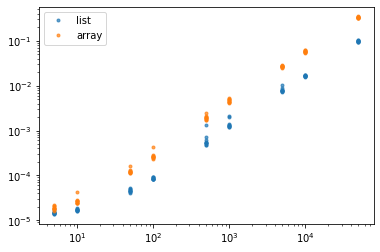

In [64]:
_ = plt.loglog(data_sizes, times_iter_qsort, '.', label='list', alpha=0.7)
_ = plt.loglog(data_sizes, times_iter_qsort_array, '.', label='array', alpha=0.7)
_ = plt.legend()

Apparently, accessing numpy array elements individually is slower than one would expect.  there are two reasons:
1. Python lists contain pointers to Python objects while a value in a numpy array a Python `float` object has to be constructed, and
1. numpy array indexing is more sophisticated (and hence slower) than Python list indexing.

## However...

Performance is not the whole story, the recursion used in the functional implementation will cause a stack overflow for long lists or lists that are (almost) sorted and not so long.

In [69]:
try:
    quicksort_functional(list(value for value in range(5_000)))
except Exception as e:
    print('error:', e, file=sys.stderr)

error: maximum recursion depth exceeded in comparison


# Character counts

In [77]:
def count_iterative(dna):
    nr_As, nr_Cs, nr_Gs, nr_Ts = 0, 0, 0, 0
    for nucl in dna:
        if nucl == 'A':
            nr_As += 1
        elif nucl == 'C':
            nr_Cs += 1
        elif nucl == 'G':
            nr_Gs += 1
        elif nucl == 'T':
            nr_Ts += 1
    return nr_As, nr_Cs, nr_Gs, nr_Ts

In [72]:
def count_iterative_hash(dna):
    counts = dict()
    for nucl in dna:
        counts[nucl] = counts.get(nucl, 0) + 1
    return counts['A'], counts['C'], counts['G'], counts['T']

In [71]:
def count_function(dna):
    return (
        dna.count('A'),
        dna.count('C'),
        dna.count('G'),
        dna.count('T'),
    )

In [75]:
dna = ''.join(random.choices('ACGT', k=1_000_000))

In [78]:
%timeit count_iterative(dna)

72.1 ms ± 909 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%timeit count_iterative_hash(dna)

78.9 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%timeit count_function(dna)

9.02 ms ± 80.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Again we get a counterintuitive result.  One would expect that iterating over a string once, as in the iterative implementation is faster than iterating over the string four times as is done in the implementation that uses `str.count`.

The reason in this case is that the `str.count` method is implemented as a C function that operates directly on the raw character representation of the Python string.

# Method resolution order

There is an oddity in the order in which Python searches for methods in an object instance.  This is illustrated in the example below.  The `say_something` method and the `__repr__` are both defined twice, once at instance level in the `__init__` function, once as methods in the class.

In [5]:
class Gadget:
    
    def __init__(self):
        self.say_something = lambda: print('hello')
        self.__repr__ = lambda: 'it is I, Leclair'
        
    def say_something(self):
        print('bye')
        
    def __repr__(self):
        return 'listen very carefully, I will say this only once'

In [2]:
gadget = Gadget()

When the `__repr__` method is invoked, the class-level method gets priority.

In [3]:
print(gadget)

listen to me very carefully, I will say this only once


However, for the `say_something` method, it is the instance method that is invoked.

In [4]:
gadget.say_something()

hello


Typically, this should not cause issues since mostly, you don't use instance methods, except... for dependency injection.

The following example illustrates this.  Animals are created with an optional function object that determines the sound the animal produces (the dependency).  If there is an instance method, it will be invoked, if not, a default method is used.

In [6]:
class Animal:
    
    def __init__(self, say=None):
        if say is not None:
            self.say = say
            
    def say(self):
        print("I've nothing to say")

In [7]:
dog = Animal(lambda: print('woof'))

In [8]:
cat = Animal(lambda: print('meow'))

In [9]:
donkey = Animal()

In [10]:
dog.say()

woof


In [11]:
cat.say()

meow


In [12]:
donkey.say()

I've nothing to say


This approach works well, but would of course fail for dunder-functions.

# Rounding

Python has a built-in `round` function that may surprise you.

In [20]:
for numerator in range(1, 11, 2):
    print(f'{numerator}/2 -> {round(numerator/2, 0)}')

1/2 -> 0.0
3/2 -> 2.0
5/2 -> 2.0
7/2 -> 4.0
9/2 -> 4.0


Python uses bankers' rounding, i.e., a floating point value is rounded to the nearest even integer.  So
* 0.5 is rounded down to 0,
* 1.5 is rounded up to 2,
* 2.5 is rounded down to 2,
* 3.5 is rounded up to 4,
* 4.5 is rounded down to 4.